In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
class TitanicData(Dataset):
    def __init__(self, train_path='./train.csv', test_path='./test.csv', sub_path='./gender_submission.csv'):
        # 读文件
        self.df_train = pd.read_csv(train_path, encoding='utf8')
        self.df_test = pd.read_csv(test_path, encoding='utf8')
        self.df_sub = pd.read_csv(sub_path, encoding='utf8')
        # 将正确解融入，方便数据预处理以及计算准确率
        self.df_test = pd.concat([self.df_test, self.df_sub['Survived']], axis=1)
        # 数据预处理（特征选择，编码）
        self.df_train = self.process_df(self.df_train)
        self.df_test = self.process_df(self.df_test)
        # 连接训练集与测试集（用来标准化）
        self.all_x = pd.concat([self.df_train.iloc[:, 1:-2], self.df_test.iloc[:, 1:-2]], axis=0)
        self.all_y = pd.concat([self.df_train.iloc[:, -2:], self.df_test.iloc[:, -2:]], axis=0)
        # 重置index（因为concat了）
        self.all_x.index = range(len(self.all_x))
        self.all_y.index = range(len(self.all_y))
        # 转化为numpy格式，提高运算性能
        self.all_x = self.all_x.values
        self.all_y = self.all_y.values
        # 标准化
        std_all = StandardScaler().fit_transform(self.all_x)
        self.all_x[:, 0] = std_all[:, 0]
        self.all_x[:, 3] = std_all[:, 3]

    def process_df(self, df):
        # 按票号排序，使数据按空间聚集
        df.sort_values(by=['Ticket'], ascending=[True], inplace=True)
        # 丢弃对结果无影响的数据
        df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
        # 对缺失项进行插值
        df['Age'].interpolate(inplace=True)
        df['Fare'].interpolate(inplace=True)
        df['Embarked'].fillna(value='S', inplace=True)
        # 恢复顺序
        df.sort_values(by=['PassengerId'], ascending=[True], inplace=True)
        # 独热编码
        df = pd.get_dummies(data=df, columns=['Sex', 'Pclass', 'Embarked', 'Survived'])
        return df

    def get_x(self, idx: int):
        return torch.Tensor(self.all_x[idx])

    def get_y(self, idx: int):
        return torch.Tensor(self.all_y[idx])

    def __getitem__(self, idx):
        return self.get_x(idx), self.get_y(idx)

    def __len__(self):
        # 仅使用训练集进行训练
        return len(self.df_train)


titanic = TitanicData()
# 使预处理后的特征便于观察
pd.DataFrame(titanic.all_x[:len(titanic), :], columns=titanic.df_train.iloc[:, 1:-2].columns)

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,-0.556215,1.0,0.0,-0.504217,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.608145,1.0,0.0,0.733260,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.265125,0.0,0.0,-0.491173,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.389827,1.0,0.0,0.381858,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.389827,0.0,0.0,-0.488757,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.192353,0.0,0.0,-0.393096,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
887,-0.774533,0.0,0.0,-0.064562,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
888,-1.017108,1.0,2.0,-0.191144,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,-0.265125,0.0,0.0,-0.064562,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [3]:
titanic.df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Age          891 non-null    float64
 2   SibSp        891 non-null    int64  
 3   Parch        891 non-null    int64  
 4   Fare         891 non-null    float64
 5   Sex_female   891 non-null    uint8  
 6   Sex_male     891 non-null    uint8  
 7   Pclass_1     891 non-null    uint8  
 8   Pclass_2     891 non-null    uint8  
 9   Pclass_3     891 non-null    uint8  
 10  Embarked_C   891 non-null    uint8  
 11  Embarked_Q   891 non-null    uint8  
 12  Embarked_S   891 non-null    uint8  
 13  Survived_0   891 non-null    uint8  
 14  Survived_1   891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(10)
memory usage: 50.5 KB


In [17]:
x, y = titanic[123]
x, y

(tensor([ 0.2079,  0.0000,  0.0000, -0.3931,  1.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  1.0000]),
 tensor([0., 1.]))

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

def train(net, loader, opt, loss):
    net.train()
    for X, y in loader:
        pred = net(X)
        l = loss(pred, y)
        opt.zero_grad()
        l.backward()
        opt.step()
        
    return l.item()

In [6]:
def parse_output(output):
    x0 = output[0].item()
    x1 = output[1].item()
    if x0 > x1:
        # return np.array([1, 0])
        return 0
    else:
        # return np.array([0, 1])
        return 1

In [7]:
model = nn.Sequential(
    nn.Linear(12, 4),
    nn.SiLU(),
    # nn.Dropout(p=0.5),
    nn.Linear(4, 2),
    nn.Sigmoid(),
    nn.Linear(2, 2),
    # nn.Sigmoid(),
    nn.Softmax(dim=0)
    )

model.apply(init_weights)
# loss = nn.CrossEntropyLoss()
loss = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loader = DataLoader(titanic, batch_size=16, shuffle=True)

all_epoch = 0
curve_list = []

In [8]:
looper = tqdm(range(100))
for i in looper:
    num_epoch = 10 # 每轮循环，训练十次
    for epoch in range(num_epoch):
        l = train(model, loader, opt, loss)
        # looper.set_description(f'loss = {round(l, 5)}')

    # 上面是训练模型，下面是统计信息，用于画图
    looper.set_description(f'loss = {round(l, 5)}')
    all_epoch += num_epoch

    true_cnt, false_cnt = 0, 0
    for idx in range(0, 891):
        pred = model(titanic[idx][0])
        real = titanic[idx][1]
        if parse_output(pred) == parse_output(real):
            true_cnt += 1
        else:
            false_cnt += 1

    curve_list.append((all_epoch, true_cnt/(true_cnt+false_cnt), l))
    # curve_list[-1]

loss = 0.36877: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


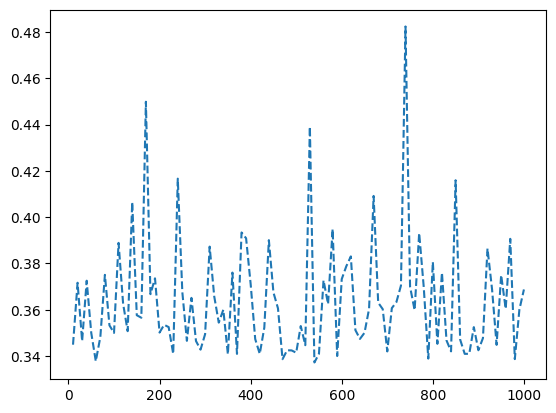

In [9]:
# plt.plot([i[0] for i in curve_list], [i[1] for i in curve_list], '--')
# 损失函数
plt.plot([i[0] for i in curve_list], [i[2] for i in curve_list], '--')

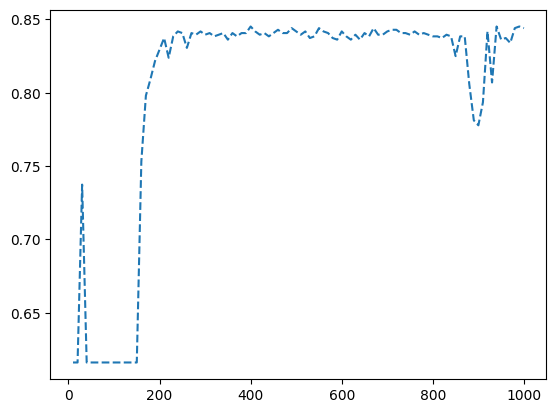

In [10]:
# 训练集上的正确率
plt.plot([i[0] for i in curve_list], [i[1] for i in curve_list], '--')

In [24]:
record = np.array([i[1] for i in curve_list])
record.argmax(), record.max()

(198, 0.8574635241301908)

In [11]:
# true_cnt, false_cnt = 0, 0
result = []
for idx in range(891, 1309):
    output = model(titanic[idx][0])
    result.append((idx + 1, parse_output(output)))
#     if parse_output(output) == parse_output(titanic[idx][1]):
#         true_cnt += 1
#     else:
#         false_cnt += 1
#
# true_cnt, false_cnt, true_cnt/(true_cnt+false_cnt)

In [12]:
res = pd.DataFrame(result, columns=['PassengerId', 'Survived'])
res.to_csv('./DNN_SiLU_1000.csv', index=None)
res

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
